
# HookNet-torch - practical guide (under construction)



We designed HookNet specifically for high-resolution images. In this practical guide, we will see how the model can train on histopathology whole slide images.

HookNet-torch is a multi-branch convolutional neural network and contains a low, mid and high(target) branch. Thereby, the model expects three patches as input. The resolution and shapes of these patches should be picked carefully as we defined some constraints to ensure that the model can correctly combine the features collected from all patches. 

This notebooks uses the **wholeslidedata>=0.1.0** python package for loading wholeslide data (images and annotations) as well as and sampling patches. HookNet-torch is a torch model and has been tested with **torch>=1.9.0+cu111**. This notebook is designed to be ran in sequence (i.e., notebook cells are depending on previous notebooks cells)

----
### 1. Installation and example data
- 1.1 installation
- 1.2 download example data

### 2. Whole slide data
- 2.1 whole slide image
- 2.2 whole slide annotation
- 2.3 batch iterator

### 3. Model training and inference
- 3.1 initialization (training)
- 3.2 training
- 3.3 initialization (inference)
- 3.4 inference


----
### 1 Installation and example data

#### 1.1 Installation

In [2]:
# install openslide-tools, ASAP or pyvips
# !pip install git+https://github.com/DIAGNijmegen/pathology-whole-slide-data@main  # for loading images,annotations and sampling
# !pip3 install gdown           # for download downloading example data

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 132 kB 12.7 MB/s eta 0:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
You should consider upgrading via the '/usr/local/bin/python3.8 -m pip install --upgrade pip' command.


#### 1.2 example data

In [1]:
# download example data
from exampledata import download_example_data
image_path, annotation_path = download_example_data()

print(f'Example image: {image_path}')
print(f'Example annotation: {annotation_path}')

Example image: /tmp/TCGA-21-5784-01Z-00-DX1.tif
Example annotation: /tmp/TCGA-21-5784-01Z-00-DX1.xml


----
### 2 Wholeslidedata

In [1]:
from matplotlib import pyplot as plt
from matplotlib import patches
from plotutils import plot_mfmr_patches, plot_sample
from wholeslidedata.iterators import create_batch_iterator

#### 2.1 WholeSlideImage

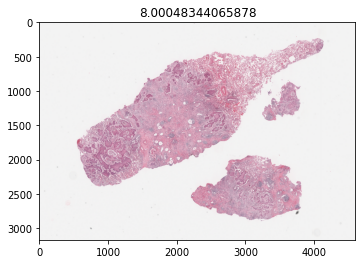

In [3]:
from wholeslidedata.image.wholeslideimage import WholeSlideImage

# spacing/resolution (4.0 um/px)
spacing_slide = 4.0

with WholeSlideImage(image_path) as wsi:
    downsampling = wsi.get_downsampling_from_spacing(spacing_slide)
    slide = wsi.get_slide(spacing_slide)
    
plt.title(f'{downsampling}')
plt.imshow(slide)
plt.show()

#### 2.2 WholeSlideAnnotation

#### 2.2.1 Annotations

annotation labels in slide: ['lymphocytes', 'stroma', 'tumor']


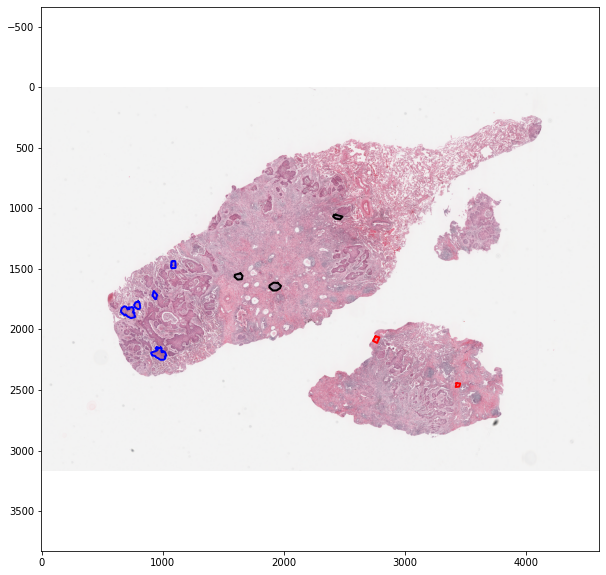

In [4]:
from wholeslidedata.annotation.wholeslideannotation import WholeSlideAnnotation
from wholeslidedata.visualization.plotting import plot_annotations

### create a whole-slide annotation
wsa = WholeSlideAnnotation(annotation_path)

# print labels of annotated regions (lymhocytes, stroma, tumor)
print(f'annotation labels in slide: {wsa.labels.names}')

### plot slide with annotations on top

# zip label_names with colors
colors = {label_name: label_color for label_name, label_color in zip(wsa.labels.names, ['black', 'red', 'blue'])}

fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.imshow(slide)
plot_annotations(annotations=wsa.annotations, ax=ax,scale=1/downsampling, color_map=colors)
plt.show()

#### 2.2.2 Multi field of view multi resolution patches

In [2]:
size = 284
low_spacing = 8.0
mid_spacing = 2.0
target_spacing = 0.5

annotation = wsa.annotations[0]
with WholeSlideImage(image_path) as wsi:
    low_patch = wsi.get_patch(*annotation.center, size, size, low_spacing)
    mid_patch = wsi.get_patch(*annotation.center, size, size, mid_spacing)
    target_patch = wsi.get_patch(*annotation.center, size, size, target_spacing)

fig, axes = plt.subplots(1,3, figsize=(20,20))
axes[0].imshow(target_patch)
axes[1].imshow(mid_patch)
axes[2].imshow(low_patch)
plt.show()

NameError: name 'wsa' is not defined

#### 2.3 Batch Iterator

batch (1, 3, 284, 284, 3)


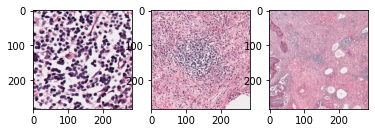

In [4]:
user_config = 'user_config_torch.yml'
mode = 'training'
number_of_batches = 1
cpus=4

with create_batch_iterator(mode=mode, 
                           user_config=user_config, 
                           number_of_batches=number_of_batches, cpus=4) as training_iterator:
    
    for x_batch, y_batch, info in training_iterator:
        print('batch', x_batch.shape)
        fig, axes = plt.subplots(1,3)
        for idx, patch in enumerate(x_batch[0]):
            axes[idx].imshow(patch)
        plt.show()
            

### 3. Model training and inference

     

In [1]:
from hooknet.model_torch import HookNet
import yaml
from tqdm.notebook import tqdm
from wholeslidedata.iterators import create_batch_iterator
import numpy as np
from wholeslidedata.visualization.plotting import plot_mask
from wholeslidedata.samplers.utils import crop_data
from plotutils import plot_inference
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from statistics import mean
import torch
from matplotlib import pyplot as plt

#### 4.1 initialization (training)

In [2]:
hooknet = HookNet(n_classes=4, n_filters=16).cuda()
criterion = CrossEntropyLoss(ignore_index=0)
optimizer = Adam(hooknet.parameters(), lr=0.005)

#### 4.2 Training

  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


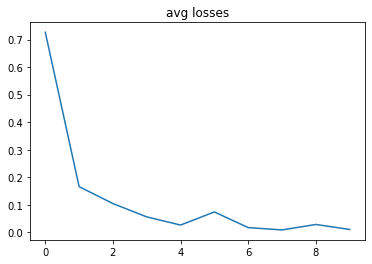

In [4]:
avg_losses = []
epochs = 10
steps = 10
with create_batch_iterator(mode='training', user_config='./user_config_torch.yml', cpus=16, buffer_dtype='uint8') as training_iterator:
    hooknet.train()
    for epoch in tqdm(range(epochs)):
        losses = []
        for step in range(steps):
            x_batch, y_batch, info = next(training_iterator)
            
            t1 = time.time()
            # spacing, channel first
            x_batch = torch.from_numpy(x_batch.transpose(1,0,4,2,3)/255.0).cuda().float()
            # get target spacing only
            y_batch = torch.from_numpy(y_batch[:,0, ...]).cuda().long()
            
            optimizer.zero_grad()
            output = hooknet(*x_batch)["out"]
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            
            losses.append(loss.item())
        avg_losses.append(mean(losses))
        
torch.save(hooknet.state_dict(), './hooknet-torch_weights.h5')
plt.title('avg losses')
plt.plot(avg_losses)
plt.show()

#### 4.3 initialization (inference)

In [5]:
number_of_batches = 6
training_iterator = create_batch_iterator(mode='training', 
                           user_config='./inference_user_config_torch.yml', 
                           number_of_batches=number_of_batches, cpus=4, buffer_dtype='uint8')

#### 4.4 inference

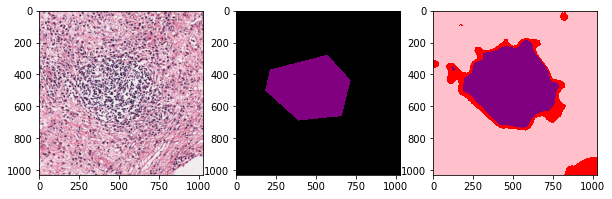

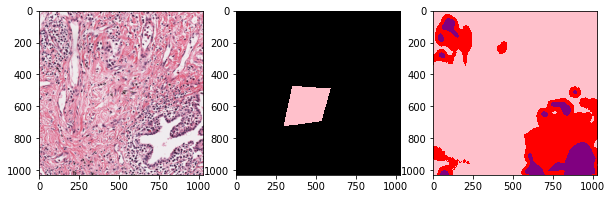

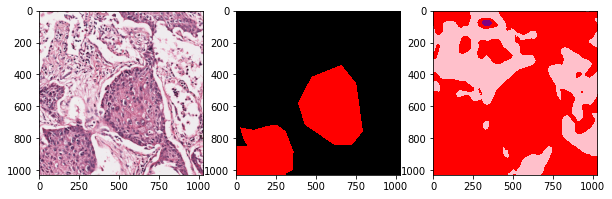

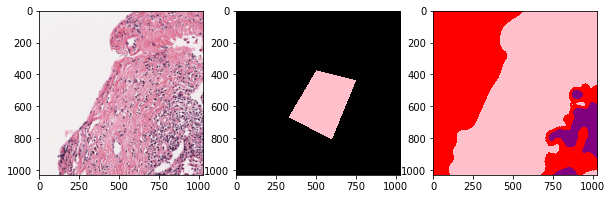

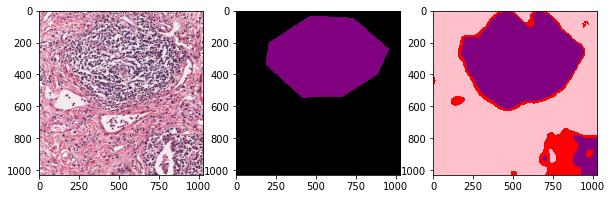

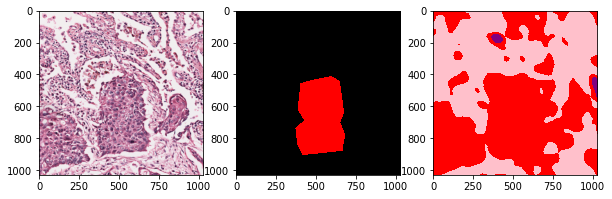

In [6]:
hooknet.eval()
for x_batch, y_batch, info in training_iterator:
    # batch, channel first
    patch = crop_data(x_batch[0][0], (1030,1030))

    x_batch = torch.from_numpy(x_batch.transpose(1,0,4,2,3)/255.0).cuda().float()
    
    with torch.no_grad():         
        output = hooknet(*x_batch)['out']

    output_patch = output[0].detach().cpu().numpy()
    
    plot_inference(patch, y_batch[0][0], np.argmax(output_patch, axis=0))